# Imports

In [1]:
from matplotlib.gridspec import GridSpec
from sklearn.model_selection import train_test_split
from minisom import MiniSom
from sklearn.preprocessing import minmax_scale, scale
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.cluster.hierarchy as shc

# Normalização

In [2]:
data_frame = pd.read_csv('Admission_Predict_Ver1.1.csv')
mediaChance = data_frame['Chance of Admit '].mean()

In [3]:
data_frame['GRE Score'] = data_frame['GRE Score'] / data_frame['GRE Score'].max()
data_frame['TOEFL Score'] = data_frame['TOEFL Score'] / data_frame['TOEFL Score'].max()
data_frame['University Rating'] = data_frame['University Rating'] / data_frame['University Rating'].max()
data_frame['SOP'] = data_frame['SOP'] / data_frame['SOP'].max()
data_frame['LOR '] = data_frame['LOR '] / data_frame['LOR '].max()
data_frame['CGPA'] = data_frame['CGPA'] / data_frame['CGPA'].max()

In [4]:
x = data_frame.drop(['Serial No.', 'Research', 'Chance of Admit '], axis=1)[['GRE Score', 'TOEFL Score', 'CGPA','SOP', 'LOR ', 'University Rating']]
y = data_frame['Chance of Admit ']
x = scale(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [5]:
data_frame[(data_frame[['Chance of Admit ']] >= mediaChance)] = 1
data_frame[(data_frame[['Chance of Admit ']] < mediaChance)] = 0

data_frame.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,0.991176,0.983333,0.8,0.9,0.9,0.972782,1,1.0
1,2,0.952941,0.891667,0.8,0.8,0.9,0.894153,1,1.0
2,3,0.929412,0.866667,0.6,0.6,0.7,0.806452,1,0.0
3,4,0.947059,0.916667,0.6,0.7,0.5,0.873992,1,1.0
4,5,0.923529,0.858333,0.4,0.4,0.6,0.827621,0,0.0


# SOM

In [10]:
size = 5
som = MiniSom(size, size, len(x[0]) , neighborhood_function='triangle', sigma=1, learning_rate = 0.5, random_seed=1)

In [11]:
som.pca_weights_init(x)
som.train_batch(x, 1000, verbose=True)

 [  490 / 1000 ]  49% 0.00041 it/s

/usr/local/lib/python3.6/dist-packages/minisom.py:251: RuntimeWarning: invalid value encountered in true_divide
  self._weights[it.multi_index] = self._weights[it.multi_index]/norm


 [  820 / 1000 ]  82% 0.00049 it/s

 [ 1000 / 1000 ] 100% 0.00050 it/s

In [8]:
qnt = som.quantization(x)
qnt[1]

array([0.38294175, 0.4187458 , 0.45763419, 0.38973257, 0.39879683,
       0.39704928])

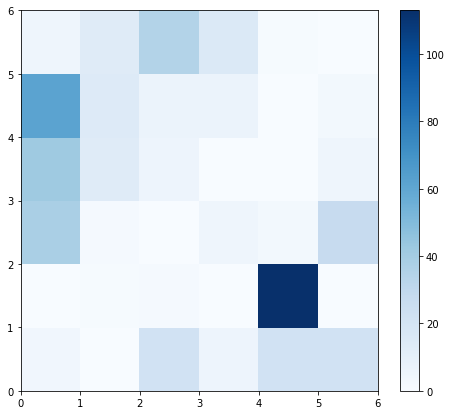

In [9]:
plt.figure(figsize=(8, 7))
frequencies = np.zeros((size, size))
for position, values in som.win_map(x).items():
    frequencies[position[0], position[1]] = len(values)
plt.pcolor(frequencies, cmap='Blues')
plt.colorbar()
plt.show()


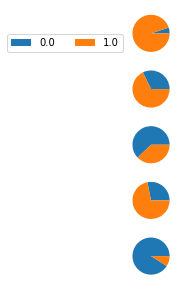

In [24]:
labels_map = som.labels_map(x, y)
label_names = np.unique(y)

plt.figure(figsize=(7, 7))
the_grid = GridSpec(7, 7)
for position in labels_map.keys():
    label_fracs = [labels_map[position][l] for l in label_names]
    plt.subplot(the_grid[6-position[1], position[0]], aspect=1)
    patches, texts = plt.pie(label_fracs)
plt.legend(patches, label_names, bbox_to_anchor=(0, 3), ncol=3)
plt.show()

# K-Means

In [12]:
kmeans = KMeans(n_clusters = 2, init = 'random')

In [13]:
kmeans.fit(x)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [14]:
kmeans.cluster_centers_

array([[-0.70443562, -0.68357288, -0.73657562, -0.69489401, -0.61574554,
        -0.67659014],
       [ 0.75100988,  0.72876778,  0.78527484,  0.74083741,  0.65645599,
         0.72132337]])

In [15]:
kmeans = KMeans(n_clusters = 2, init = 'random')
y_pred = kmeans.fit_predict(x)

metrics.fowlkes_mallows_score(y, y_pred)

0.7526171318097126

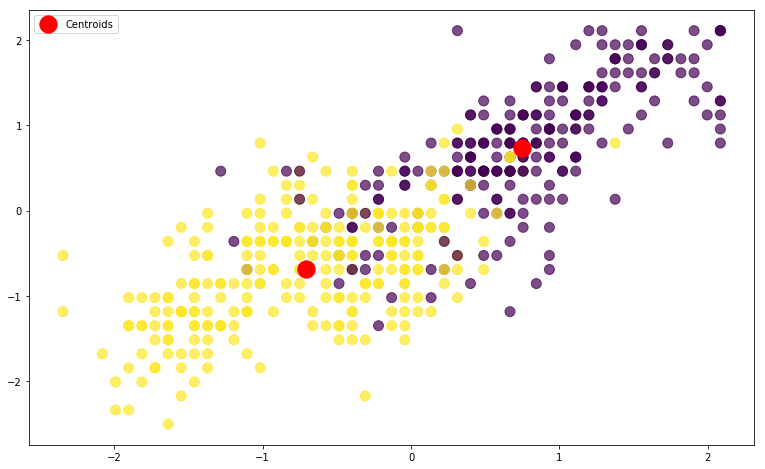

In [16]:
plt.rcParams['figure.figsize'] = (13,8)
plt.scatter(x[:, 0], x[:, 1], s = 100, c = kmeans.labels_, alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'red',label = 'Centroids')
plt.legend()

plt.show()

# Hierárquico

In [17]:
hierarquica = AgglomerativeClustering(n_clusters=2, linkage='single')
y_pred = hierarquica.fit_predict(x)

metrics.fowlkes_mallows_score(y, y_pred)

0.7049837819222581

In [18]:
hierarquica = AgglomerativeClustering(n_clusters=2, linkage='average')
y_pred = hierarquica.fit_predict(x)

metrics.fowlkes_mallows_score(y, y_pred)

0.6732799451869657

In [19]:
hierarquica = AgglomerativeClustering(n_clusters=2, linkage='ward')
y_pred = hierarquica.fit_predict(x)

metrics.fowlkes_mallows_score(y, y_pred)

0.7405482923245276

No handles with labels found to put in legend.


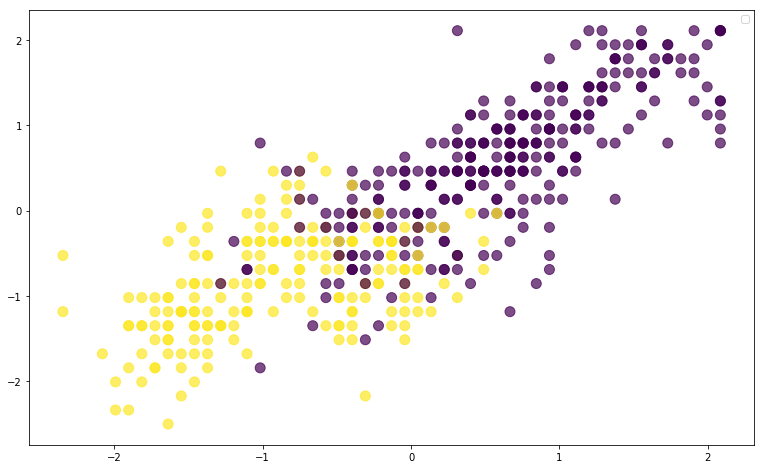

In [20]:
plt.rcParams['figure.figsize'] = (13,8)
plt.scatter(x[:, 0], x[:, 1], s = 100, c = y_pred, alpha=0.7)
plt.legend()

plt.show()

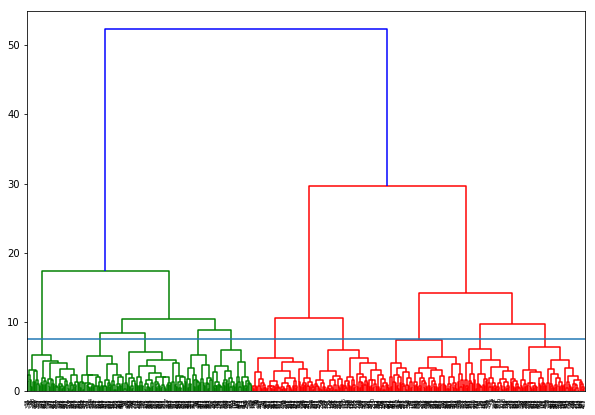

In [21]:
plt.figure(figsize=(10, 7))
d = shc.dendrogram(shc.linkage(x, method='ward'))
plt.axhline(y=7.5)
plt.show()